In [1]:
import pandas as pd
import chess
from tqdm.notebook import tqdm
import numpy as np

In [2]:
db = pd.read_csv('db_mi1_movemade.csv')
del db['Unnamed: 0']
db

,index,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl
0,47,004iZ,r2r2k1/2q1bpp1/3p3p/1ppn4/1P1BP3/P5Q1/4RPPP/R5...,f6d5 g3g7,1026,75,98,565,kingsideAttack mate mateIn1 middlegame oneMove,https://lichess.org/dQ85JUe1/black#40
1,51,004zI,2q3k1/4br2/6pQ/1p1n2p1/7P/1P4P1/1B2PP2/6K1 w -...,h7g6 h6h8,1398,81,88,127,endgame mate mateIn1 oneMove,https://lichess.org/HE33gdt4/black#54
2,86,008Nz,6k1/2p2ppp/pnp5/B7/2P3PP/1P2PPR1/r3b2r/3R2K1 w...,d3e2 d1d8,661,100,85,258,backRankMate mate mateIn1 middlegame oneMove,https://lichess.org/HNU4zavC/black#58
3,154,00FHX,2r3k1/5p1p/4pP2/3p3P/8/5P2/p5P1/1bR3K1 w - - 1 31,c2b1 c1c8,957,156,100,38,endgame hangingPiece mate mateIn1 oneMove,https://lichess.org/rztVgThB/black#60
4,161,00GRa,1r3rk1/2p1qppb/p2n4/1p2p1Pp/4Qn1P/2P1N3/PPB2P1...,e6e7 e4h7,650,108,91,325,kingsideAttack mate mateIn1 middlegame oneMove,https://lichess.org/QiJhfG8J/black#56
...,...,...,...,...,...,...,...,...,...,...
80904,2329219,zzn41,5r1k/1R4R1/p4p1p/7q/6N1/PB5P/1r3PPK/8 w - - 1 35,h7h8 g7h7,1381,388,37,8,mate mateIn1 middlegame oneMove,https://lichess.org/hbZucpSh/black#68
80905,2329269,zzrpZ,1rbqkbnr/3p2pp/p4p2/1ppQ4/2B1P3/8/PPP2PPP/RNB1...,a8b8 d5f7,1191,92,100,87,mate mateIn1 oneMove opening,https://lichess.org/rU9B6vJq/black#18
80906,2329285,zztSE,6k1/1qr3pp/1p2pp2/p2b4/Q2P1N2/P1r2P1P/1P4P1/2R...,c6c3 a4e8,1056,79,78,357,mate mateIn1 middlegame oneMove,https://lichess.org/8kuswPiB/black#56
80907,2329294,zzuD3,r5rk/ppp2p2/1bPp3p/1B6/4P3/7Q/PP3qP1/R3N2K w -...,h4f2 h3h6,1414,142,29,39,kingsideAttack master mate mateIn1 middlegame ...,https://lichess.org/RWXAWcFJ/black#52


In [3]:
db.loc[0]['FEN']

'r2r2k1/2q1bpp1/3p3p/1ppn4/1P1BP3/P5Q1/4RPPP/R5K1 w - - 0 21'

In [4]:
# ideas

### input 8x8x13 board encoding (as there are 12 pieces and empty squares in chess) ###
# 1 pawn
# 2 rook
# 3 knight 
# 4 bishop
# 5 queen
# 6 king
# 7 bpawn
# ...

### output: predicted move encoded between 0-4095 (as the board is 64x64) ###


In [5]:
piece_dict ={ 
    'empty':0,
    'P':1,
    'R':2,
    'N':3,
    'B':4,
    'Q':5,
    'K':6,
    'p':7,
    'r':8,
    'n':9,
    'b':10,
    'q':11,
    'k':12,                  
}


#example fen 'r2r2k1/2q1bpp1/3p1n1p/1ppN4/1P1BP3/P5Q1/4RPPP/R5K1'
def fen_to_encoded(fen):
    field = np.zeros((8, 8, 13), dtype=bool)
    fen_by_row = fen.split(' ')[0].split('/')[::-1]
    for row in range(8):
        col = 0
        #parse char
        for char in fen_by_row[row]:
            if char.isnumeric():
                # place empties, dunno if this helps the NN
                field[row, col:col+int(char), 0] = 1
                col+=int(char)
            else:
                piece = piece_dict[char]
                # place piece
                field[row, col, piece] = 1
                col+=1
    return field
    

In [6]:
alphabet_dict = {
                'a': 0,
                'b': 1,
                'c': 2,
                'd': 3,
                'e': 4,
                'f': 5,
                'g': 6,
                'h': 7
                }

reversed_alphabet_dict = {v: k for k, v in alphabet_dict.items()}

# https://stackoverflow.com/questions/46732213/mapping-two-integers-to-one-with-an-upperbound
#If you have two numbers

#    a from 0 to a_max - 1
#    b from 0 to 2^32/a_max - 1
# you can combine them as x = a + a_max*b;
#and the combined number x will fit into a 32 bit unsigned integer.

#To decode them, use
#a = x%a_max;
#b = x/a_max;

def encode_move(move):
    pos1, pos2 = move[:2], move[2:]
    pos1_int = alphabet_dict[pos1[0]]*8+int(pos1[1])-1
    pos2_int = alphabet_dict[pos2[0]]*8+int(pos2[1])-1

    return pos1_int+(64*pos2_int)

def decode_move(move_int):
    pos1_int = move_int%64
    pos2_int = move_int//64
    pos1_str = reversed_alphabet_dict[(pos1_int//8)]+str((pos1_int%8)+1)
    pos2_str = reversed_alphabet_dict[(pos2_int//8)]+str((pos2_int%8)+1)
    
    return pos1_str+pos2_str
    

board = chess.Board(db.loc[0]['FEN'])

# legal move 0.1, correct move 1, illegal move 0
def generate_nn_input(board, best_move):
    # a1 = 1, h8 = 64
    best_move = encode_move(best_move)
    
    legal_moves = [str(m) for m in list(board.legal_moves)]
    legal_moves = [encode_move(m) for m in legal_moves]
    
    nn_input_legal = np.zeros(4096, np.float16)
    nn_input_best = np.zeros(4096, np.float16)
    nn_input_legal[legal_moves] = 1
    nn_input_best[best_move] = 1
    
    return {'best': nn_input_best,
            'legal': nn_input_legal}


In [7]:
len(db)

80909

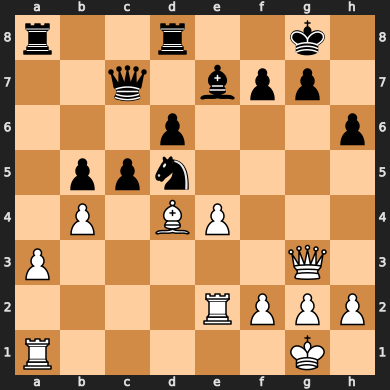

In [8]:
fen = db.loc[0]['FEN']
board = chess.Board(fen)
board

## Dataset

In [9]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MateInOneDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fen = self.df.loc[idx]['FEN']
        board = chess.Board(fen)
        best_move = self.df.loc[idx]['Moves'].split(' ')[1]
        
        field = fen_to_encoded(fen)
        target = generate_nn_input(board=board, best_move=best_move)
        return field, target

In [10]:
train_db = db.sample(frac=0.8, random_state=912).reset_index()
valid_db = db.drop(train_db.index).reset_index()

In [11]:
worker_init_fn=lambda id: np.random.seed(torch.initial_seed() // 2**32 + id)
bs=64
train_loader = DataLoader(MateInOneDataset(train_db), batch_size=bs, shuffle=True, worker_init_fn=worker_init_fn, drop_last=True)
valid_loader = DataLoader(MateInOneDataset(valid_db), batch_size=bs, shuffle=False, worker_init_fn=worker_init_fn, drop_last=True)

## Modeling

### The model predicts 2 things, the best move and all legal moves

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        self.kernel_size = kernel_size
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, 3, 1, 1, bias=True), # No batchNorm so let's use bias
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels//2, out_channels//2, 3, 1, 1, bias=True),
            nn.ReLU(inplace=True),
            #nn.Dropout2d(p=0.2, inplace=True)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv8x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, (kernel_size, 1), (kernel_size, 1), 0, bias=True),
            nn.ReLU(inplace=True),
        )
        self.conv1x8 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, (1, kernel_size), (1, kernel_size), 0, bias=True),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x_3by3 = self.conv3x3(x)
        x_8by1 = self.pool(self.conv8x1(x).repeat(1, 1, self.kernel_size, 1))
        x_1by8 = self.pool(self.conv1x8(x).repeat(1, 1, 1, self.kernel_size))
        x = torch.cat((x_3by3, x_8by1, x_1by8), 1)
        return x

# Basic, no residual connections or fancy stuff
class ChessModel(nn.Module):
    def __init__(self, in_channels=13):
        super(ChessModel, self).__init__()
        #conv_3x3 = nn.Conv2d(13, 128, kernel_size=3, 1, 1, bias=True)
        self.conv1 = ConvBlock(in_channels, 256, kernel_size=8)
        self.conv2 = ConvBlock(256, 512, kernel_size=4)   
        self.conv3 = ConvBlock(512, 1024, kernel_size=1)
        self.fc_best = nn.Linear(1024, 4096)
        self.fc_legal = nn.Linear(1024, 4096)
        
    def forward(self, x):
        # mix 8x1, 1x8 and 3x3 convs
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.conv3(x).squeeze(-1).squeeze(-1)
        #print(x.shape)
        
        return {'best': self.fc_best(x),
                'legal': torch.sigmoid(self.fc_legal(x))
                }

In [13]:
#import custom_resnet

In [14]:
model = ChessModel()
#pass
#model = custom_resnet.ResNet50(img_channel=13, num_classes=4096)

In [15]:
def accuracy(pred, gt):
    pred = torch.argmax(pred, dim=1)
    gt = torch.argmax(gt, dim=1)
    
    return (torch.count_nonzero(pred==gt)/len(pred)).item()

def precision_recall(pred, gt):
    tp = torch.sum(pred * gt)
    fp = torch.sum(pred) - tp
    fn = torch.sum(gt) - tp
    prec = (tp+1e-7)/(tp+fp+1e-7)
    rec = (tp+1e-7)/(tp+fn+1e-7)
    
    return prec.item(), rec.item()
    

In [ ]:
import neptune.new as neptune

run = neptune.init(
    project="",
    api_token="",
)  # your credentials

    



In [17]:
epochs = 100
device = 'cuda:0'
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn_best = nn.CrossEntropyLoss()
loss_fn_legal = nn.MSELoss()
#loss_fn_legal = utils.losses.JaccardLoss()
model.to(device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.67, patience=5, threshold=0.00001)
len_train = len(train_loader)
len_valid = len(valid_loader)
best_val_loss = 9999
for i in range(epochs):
    print('Epoch', i)
    print('Train')
    param_group = optimizer.param_groups[0]
    current_lr = param_group['lr']
    print('Learning rate:', current_lr)
    with tqdm(train_loader, unit="batch") as tepoch:
        loss_sum, acc_sum, prec_sum, rec_sum = 0., 0., 0., 0.
        for j, (field, target) in enumerate(tepoch):
            field = field.to(device).float()
            target_best = target['best'].to(device).float()
            target_legal = target['legal'].to(device).float()
            
            field = torch.permute(field, (0, 3, 1, 2))

            optimizer.zero_grad()
            output = model(field)
            
            loss_best = loss_fn_best(output['best'], target_best)
            loss_legal = loss_fn_legal(output['legal'], target_legal)
            loss = (loss_best/50) + (loss_legal*50)
            #print(loss_best, loss_legal)
            loss.backward()
            optimizer.step()
            
            acc_best = accuracy(output['best'], target_best)
            precision, recall = precision_recall(output['legal'].round(), target_legal)
            
            loss_sum += loss.item()
            acc_sum += acc_best
            prec_sum += precision
            rec_sum += recall
            
            tepoch.set_postfix(loss=loss_sum/(j+1), acc_best=acc_sum/(j+1), pr_legal=prec_sum/(j+1), rec_legal=rec_sum/(j+1))
        run["train/acc_best"].log(acc_sum/len(tepoch))
        run["train/precision_legal"].log(prec_sum/len(tepoch))
        run["train/recall_legal"].log(rec_sum/len(tepoch))
        run["train/loss"].log((loss_sum/len(tepoch)))
                                         
        loss_sum, acc_sum, prec_sum, rec_sum = 0., 0., 0., 0.
    print('Valid')
    with tqdm(valid_loader, unit="batch") as vepoch:    
        for j, (field, target) in enumerate(vepoch):
            field = field.to(device).float()
            target_best = target['best'].to(device).float()
            target_legal = target['legal'].to(device).float()
            field = torch.permute(field, (0, 3, 1, 2))
            with torch.no_grad():
                output = model(field)
                
            loss_best = loss_fn_best(output['best'], target_best)
            loss_legal = loss_fn_legal(output['legal'], target_legal)
            loss = (loss_best/50) + (loss_legal*50)
            
            acc_best = accuracy(output['best'], target_best)
            precision, recall = precision_recall(output['legal'].round(), target_legal)
            
            loss_sum += loss.item()
            acc_sum += acc_best
            prec_sum += precision
            rec_sum += recall
            
            vepoch.set_postfix(loss=loss_sum/(j+1), acc_best=acc_sum/(j+1), pr_legal=prec_sum/(j+1), rec_legal=rec_sum/(j+1))
        run["val/acc_best"].log(acc_sum/len(vepoch))
        run["val/precision_legal"].log(prec_sum/len(vepoch))
        run["val/recall_legal"].log(rec_sum/len(vepoch))
        run["val/loss"].log(loss_sum/len(vepoch))
        
        scheduler.step(loss_sum/len(vepoch))
        if loss_sum/len(vepoch) <= best_val_loss:
            print('New validation loss record', loss_sum/len(vepoch))
            best_val_loss = loss_sum #woops, this just pretty much saves every epoch
            #best_val_loss = loss_sum/len(vepoch)
            torch.save(model.state_dict(), 'mate_in_one.pt')
        print('======================================')


Epoch 0
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.27683278876874184
Epoch 1
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.13624669102922318
Epoch 2
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.08877065405249596
Epoch 3
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.06524807191084302
Epoch 4
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.053263478439360384
Epoch 5
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.045939313913030286
Epoch 6
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.04105827457729786
Epoch 7
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03876716514960641
Epoch 8
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03637055124318789
Epoch 9
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03453085527178787
Epoch 10
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03330637918903478
Epoch 11
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.033469887250768285
Epoch 12
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.032536615144520525
Epoch 13
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.032724533207891954
Epoch 14
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03213630464401037
Epoch 15
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03151258522467244
Epoch 16
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03216795122901362
Epoch 17
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.032828087826067255
Epoch 18
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03257560943962917
Epoch 19
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.032675776493898225
Epoch 20
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03259652420242746
Epoch 21
Train
Learning rate: 0.001


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.0323606091292782
Epoch 22
Train
Learning rate: 0.00067


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.028175778716566072
Epoch 23
Train
Learning rate: 0.00067


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.028380800762938127
Epoch 24
Train
Learning rate: 0.00067


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.028579980179312684
Epoch 25
Train
Learning rate: 0.00067


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.028824088751294073
Epoch 26
Train
Learning rate: 0.00067


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02919936933672972
Epoch 27
Train
Learning rate: 0.00067


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029293115167612477
Epoch 28
Train
Learning rate: 0.00067


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029057513698861594
Epoch 29
Train
Learning rate: 0.0004489


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.027154136833453937
Epoch 30
Train
Learning rate: 0.0004489


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.028522887801204527
Epoch 31
Train
Learning rate: 0.0004489


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02874128189721396
Epoch 32
Train
Learning rate: 0.0004489


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02881867569383411
Epoch 33
Train
Learning rate: 0.0004489


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02935719843362532
Epoch 34
Train
Learning rate: 0.0004489


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029427016974382457
Epoch 35
Train
Learning rate: 0.0004489


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029647089877269335
Epoch 36
Train
Learning rate: 0.000300763


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.028813108949670718
Epoch 37
Train
Learning rate: 0.000300763


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.028599238954484463
Epoch 38
Train
Learning rate: 0.000300763


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029387847431713625
Epoch 39
Train
Learning rate: 0.000300763


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029551548838970206
Epoch 40
Train
Learning rate: 0.000300763


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02948266696665318
Epoch 41
Train
Learning rate: 0.000300763


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02985647894878177
Epoch 42
Train
Learning rate: 0.00020151121


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02922449317125101
Epoch 43
Train
Learning rate: 0.00020151121


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029048213744462127
Epoch 44
Train
Learning rate: 0.00020151121


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029498370744967983
Epoch 45
Train
Learning rate: 0.00020151121


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029298388663428054
Epoch 46
Train
Learning rate: 0.00020151121


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029515475797880854
Epoch 47
Train
Learning rate: 0.00020151121


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03008921734715206
Epoch 48
Train
Learning rate: 0.0001350125107


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02973243507320091
Epoch 49
Train
Learning rate: 0.0001350125107


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02945574327364623
Epoch 50
Train
Learning rate: 0.0001350125107


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029734633277199926
Epoch 51
Train
Learning rate: 0.0001350125107


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029952795551498494
Epoch 52
Train
Learning rate: 0.0001350125107


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029704061802476645
Epoch 53
Train
Learning rate: 0.0001350125107


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02989832076635803
Epoch 54
Train
Learning rate: 9.045838216900001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02968404175610178
Epoch 55
Train
Learning rate: 9.045838216900001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029890426700668677
Epoch 56
Train
Learning rate: 9.045838216900001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029818558799368993
Epoch 57
Train
Learning rate: 9.045838216900001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029976168283379623
Epoch 58
Train
Learning rate: 9.045838216900001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029973217511608724
Epoch 59
Train
Learning rate: 9.045838216900001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.030006884222125843
Epoch 60
Train
Learning rate: 6.060711605323001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03008665270652504
Epoch 61
Train
Learning rate: 6.060711605323001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.030026212351263633
Epoch 62
Train
Learning rate: 6.060711605323001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.03007100986331583
Epoch 63
Train
Learning rate: 6.060711605323001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029962533486208746
Epoch 64
Train
Learning rate: 6.060711605323001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.030072124098383245
Epoch 65
Train
Learning rate: 6.060711605323001e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.030003991000176894
Epoch 66
Train
Learning rate: 4.060676775566411e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02994771752070399
Epoch 67
Train
Learning rate: 4.060676775566411e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029925855905896734
Epoch 68
Train
Learning rate: 4.060676775566411e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029928212621367523
Epoch 69
Train
Learning rate: 4.060676775566411e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029967737714907836
Epoch 70
Train
Learning rate: 4.060676775566411e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029896178816829527
Epoch 71
Train
Learning rate: 4.060676775566411e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029828264993349358
Epoch 72
Train
Learning rate: 2.7206534396294953e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02981135919357517
Epoch 73
Train
Learning rate: 2.7206534396294953e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029858749869856097
Epoch 74
Train
Learning rate: 2.7206534396294953e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029811386752592785
Epoch 75
Train
Learning rate: 2.7206534396294953e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02982374746167648
Epoch 76
Train
Learning rate: 2.7206534396294953e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029846753274637556
Epoch 77
Train
Learning rate: 2.7206534396294953e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029872785218887858
Epoch 78
Train
Learning rate: 1.822837804551762e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.02993190797444965
Epoch 79
Train
Learning rate: 1.822837804551762e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029909866854607586
Epoch 80
Train
Learning rate: 1.822837804551762e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029896127078534354
Epoch 81
Train
Learning rate: 1.822837804551762e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

Valid


  0%|          | 0/252 [00:00<?, ?batch/s]

New validation loss record 0.029821721726052818
Epoch 82
Train
Learning rate: 1.822837804551762e-05


  0%|          | 0/1011 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## Test

In [18]:
def get_fp_fn(pred, gt):
    tp = (pred * gt)
    fp = pred - tp
    fn = gt - tp
    
    return {'fp': [decode_move(fp_int[0]) for fp_int in torch.nonzero(fp).cpu().detach().numpy()],
            'fn': [decode_move(fn_int[0]) for fn_int in torch.nonzero(fn).cpu().detach().numpy()]}

In [19]:
def test(p):
    print('n', p, 'rating', valid_db.loc[p]['Rating'], 'rating deviation', valid_db.loc[p]['RatingDeviation'])
    fen = valid_db.loc[p]['FEN']
    board = chess.Board(fen)
    best_move = valid_db.loc[p]['Moves'].split(' ')[1]
    best_move_encoded = generate_nn_input(board, best_move)

    nn_move = model(torch.Tensor(fen_to_encoded(fen)).to(device).unsqueeze(0).permute(0, 3, 1, 2))
    print('Best move:', best_move)
    print('Predicted move:', decode_move(torch.argmax(nn_move['best']).item()))
    fpfn = get_fp_fn(nn_move['legal'].round().cpu().detach().squeeze(0), torch.Tensor(best_move_encoded['legal']).squeeze(0))
    print('FP legal:', fpfn['fp'])
    print('FN legal:', fpfn['fn'])
    
    return board


In [20]:
hard_ones = []
for p in range(len(valid_db)):
    if valid_db.loc[p]['Rating'] >=1800:
        hard_ones.append(p)


n 14089 rating 1888 rating deviation 75
Best move: h7b1
Predicted move: h7b1
FP legal: []
FN legal: []


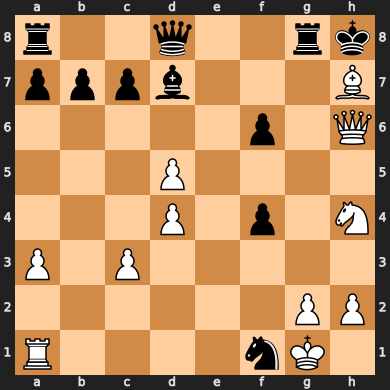

In [21]:
#p = np.random.randint(10000)
p = np.random.choice(hard_ones)
test(p)


n 15126 rating 1844 rating deviation 81
Best move: c5a6
Predicted move: c5a6
FP legal: []
FN legal: ['g3h4']


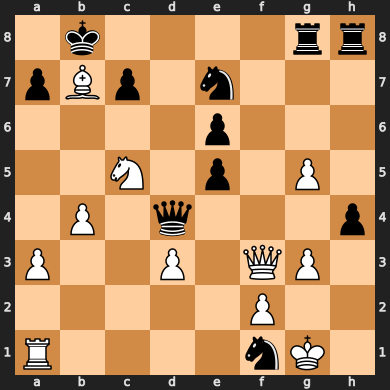

In [22]:
p = np.random.choice(hard_ones)
test(p)    

n 7939 rating 1905 rating deviation 84
Best move: g7f7
Predicted move: g7f7
FP legal: []
FN legal: []


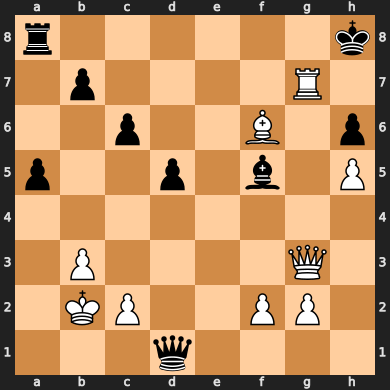

In [23]:
p = np.random.choice(hard_ones)
test(p)

n 791 rating 1914 rating deviation 109
Best move: f1d2
Predicted move: f1d2
FP legal: []
FN legal: ['f1d2', 'f1e3', 'f1g3', 'f1h2']


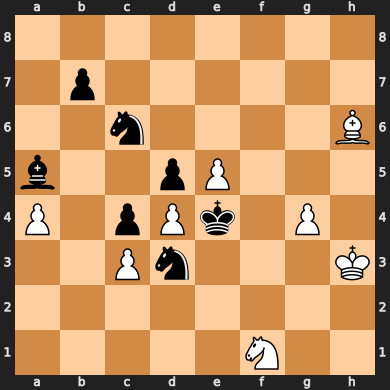

In [24]:
p = np.random.choice(hard_ones)
test(p)